# 快速入门

本案例通过MindSpore的API来快速实现一个简单的深度学习模型。

## 环境准备

开发者拿到香橙派开发板后，首先需要进行硬件资源确认、镜像烧录以及CANN和MindSpore版本的升级，才可运行该案例，具体如下：

| 香橙派AIpro | 镜像 | CANN Toolkit/Kernels | MindSpore |
| :----:| :----: | :----:| :----: |
| 8T 8G | Ubuntu | 8.1.RC1 | 2.6.0 |

### 镜像烧录

运行该案例需要烧录香橙派官网Ubuntu镜像，参考[镜像烧录](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/orange_pi/environment_setup.html#1-%E9%95%9C%E5%83%8F%E7%83%A7%E5%BD%95%E4%BB%A5windows%E7%B3%BB%E7%BB%9F%E4%B8%BA%E4%BE%8B)章节。

### CANN升级

参考[CANN升级](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/orange_pi/environment_setup.html#3-cann%E5%8D%87%E7%BA%A7)章节。

### MindSpore升级

参考[MindSpore升级](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/orange_pi/environment_setup.html#4-mindspore%E5%8D%87%E7%BA%A7)章节。

In [1]:
import mindspore
from mindspore import mint
from mindspore.nn import Cell, SGD
from mindspore.mint import nn
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset

/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## 数据集准备与加载

MindSpore提供基于Pipeline的[数据引擎](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/design/data_engine.html)，通过[数据集（Dataset）](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0rc1/beginner/dataset.html)实现高效的数据预处理。在本案例中，我们使用Mnist数据集，自动下载完成后，使用`mindspore.dataset`提供的数据变换进行预处理。


In [3]:
# install download

!pip install download

In [4]:
# Download data from open datasets
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 12.6MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


MNIST数据集目录结构如下：

```text
MNIST_Data
└── train
    ├── train-images-idx3-ubyte (60000个训练图片)
    ├── train-labels-idx1-ubyte (60000个训练标签)
└── test
    ├── t10k-images-idx3-ubyte (10000个测试图片)
    ├── t10k-labels-idx1-ubyte (10000个测试标签)

```

数据下载完成后，获得数据集对象。

In [5]:
train_dataset = MnistDataset('MNIST_Data/train')
test_dataset = MnistDataset('MNIST_Data/test')

打印数据集中包含的数据列名，用于dataset的预处理。

In [6]:
print(train_dataset.get_col_names())

['image', 'label']


MindSpore的dataset使用数据处理流水线（Data Processing Pipeline），需指定map、batch、shuffle等操作。这里我们使用map对图像数据及标签进行变换处理，将输入的图像缩放为1/255，根据均值0.1307和标准差值0.3081进行归一化处理，然后将处理好的数据集打包为大小为64的batch。

In [7]:
def datapipe(dataset, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW(),
        transforms.TypeCast(mindspore.float16)
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset

In [8]:
# Map vision transforms and batch dataset
train_dataset = datapipe(train_dataset, 64)
test_dataset = datapipe(test_dataset, 64)

可使用[create_tuple_iterator](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/dataset/dataset_method/iterator/mindspore.dataset.Dataset.create_tuple_iterator.html) 或[create_dict_iterator](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/dataset/dataset_method/iterator/mindspore.dataset.Dataset.create_dict_iterator.html)对数据集进行迭代访问，查看数据和标签的shape和datatype。

In [9]:
for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

Shape of image [N, C, H, W]: (64, 1, 28, 28) Float16
Shape of label: (64,) Int32


In [10]:
for data in test_dataset.create_dict_iterator():
    print(f"Shape of image [N, C, H, W]: {data['image'].shape} {data['image'].dtype}")
    print(f"Shape of label: {data['label'].shape} {data['label'].dtype}")
    break

Shape of image [N, C, H, W]: (64, 1, 28, 28) Float16
Shape of label: (64,) Int32


## 模型构建

In [11]:
# Define model
class Network(Cell):
    def __init__(self):
        super().__init__()
        self.flatten = mint.flatten
        self.dense1 = nn.Linear(28*28, 512, dtype=mindspore.float16)
        self.dense2 = nn.Linear(512, 512, dtype=mindspore.float16)
        self.dense3 = nn.Linear(512, 10, dtype=mindspore.float16)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.flatten(x, start_dim=1)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        logits = self.dense3(x)
        return logits

model = Network()
print(model)

Network(
  (dense1): Linear(input_features=784, output_features=512, has_bias=True)
  (dense2): Linear(input_features=512, output_features=512, has_bias=True)
  (dense3): Linear(input_features=512, output_features=10, has_bias=True)
  (relu): ReLU()
)


## 模型训练

在模型训练中，一个完整的训练过程（step）需要实现以下三步：

1. **正向计算**：模型预测结果（logits），并与正确标签（label）求预测损失（loss）。
2. **反向传播**：利用自动微分机制，自动求模型参数（parameters）对于loss的梯度（gradients）。
3. **参数优化**：将梯度更新到参数上。

MindSpore使用函数式自动微分机制，因此针对上述步骤需要实现：

1. 定义正向计算函数。
2. 使用[value_and_grad](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/mindspore/mindspore.value_and_grad.html)通过函数变换获得梯度计算函数。
3. 定义训练函数，使用[set_train](https://www.mindspore.cn/docs/zh-CN/r2.6.0rc1/api_python/nn/mindspore.nn.Cell.html#mindspore.nn.Cell.set_train)设置为训练模式，执行正向计算、反向传播和参数优化。

In [12]:
# Instantiate loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.trainable_params(), 1e-2)

# 1. Define forward function
def forward_fn(data, label):
    logits = model(data)
    loss = loss_fn(logits, label)
    return loss, logits

# 2. Get gradient function
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

# 3. Define function of one-step training
def train_step(data, label):
    (loss, _), grads = grad_fn(data, label)
    optimizer(grads)
    return loss

def train(model, dataset):
    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

除训练外，我们定义测试函数，用来评估模型的性能。

In [13]:
def test(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (mint.argmax(pred, dim=1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

训练过程需多次迭代数据集，一次完整的迭代称为一轮（epoch）。在每一轮，遍历训练集进行训练，结束后使用测试集进行预测。打印每一轮的loss值和预测准确率（Accuracy），可以看到loss在不断下降，Accuracy在不断提高。

In [14]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model, train_dataset)
    test(model, test_dataset, loss_fn)
print("Done!")

Epoch 1
-------------------------------
.loss: 2.291016  [  0/938]
loss: 1.763672  [100/938]
loss: 0.964844  [200/938]
loss: 0.760742  [300/938]
loss: 0.473633  [400/938]
loss: 0.449951  [500/938]
loss: 0.392822  [600/938]
loss: 0.382324  [700/938]
loss: 0.485352  [800/938]
loss: 0.181885  [900/938]


[WARNING] MD(5139,e7ff1078f120,python):2025-07-22-11:36:29.654.799 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:146] operator()] Memory consumption is more than 81.9409%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(5139,e7ff127cf120,python):2025-07-22-11:36:33.235.978 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:146] operator()] Memory consumption is more than 81.6789%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


Test: 
 Accuracy: 91.0%, Avg loss: 0.318458 

Epoch 2
-------------------------------
loss: 0.329834  [  0/938]
loss: 0.429443  [100/938]
loss: 0.292236  [200/938]
loss: 0.353760  [300/938]
loss: 0.437988  [400/938]
loss: 0.250000  [500/938]
loss: 0.245605  [600/938]
loss: 0.257080  [700/938]
loss: 0.243530  [800/938]
loss: 0.173096  [900/938]


[WARNING] MD(5139,e7ff127cf120,python):2025-07-22-11:37:03.800.668 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:146] operator()] Memory consumption is more than 80.8599%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(5139,e7ff127cf120,python):2025-07-22-11:37:06.621.141 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:146] operator()] Memory consumption is more than 80.2724%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


Test: 
 Accuracy: 92.7%, Avg loss: 0.255700 

Epoch 3
-------------------------------
loss: 0.205933  [  0/938]
loss: 0.176758  [100/938]
loss: 0.459473  [200/938]
loss: 0.161255  [300/938]
loss: 0.222412  [400/938]
loss: 0.169067  [500/938]
loss: 0.314453  [600/938]
loss: 0.080139  [700/938]
loss: 0.415771  [800/938]
loss: 0.241455  [900/938]


[WARNING] MD(5139,e7fedd40f120,python):2025-07-22-11:37:29.669.746 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:146] operator()] Memory consumption is more than 80.8526%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.
[WARNING] MD(5139,e7ff127cf120,python):2025-07-22-11:37:32.509.860 [mindspore/ccsrc/minddata/dataset/engine/datasetops/batch_op.cc:146] operator()] Memory consumption is more than 80.259%, which may cause OOM. Please reduce num_parallel_workers size / optimize 'per_batch_map' function / other python data preprocess function to reduce memory usage.


Test: 
 Accuracy: 93.6%, Avg loss: 0.212445 

Done!


## 保存模型

模型训练完成后，需要将其参数进行保存。

In [15]:
# Save checkpoint
mindspore.save_checkpoint(model, "model.ckpt")
print("Saved Model to model.ckpt")

Saved Model to model.ckpt


## 权重加载

加载保存的权重分为两步：

1. 重新实例化模型对象，构造模型。
2. 加载模型参数，并将其加载至模型上。

In [16]:
# Instantiate a random initialized model
model = Network()
# Load checkpoint and load parameter to model
param_dict = mindspore.load_checkpoint("model.ckpt")
param_not_load, _ = mindspore.load_param_into_net(model, param_dict)
print(param_not_load)

[]


> `param_not_load`是未被加载的参数列表，为空时代表所有参数均加载成功。

## 模型推理

加载后的模型可以直接用于预测推理。

Predicted: "[2 1 1 5 7 8]", Actual: "[2 1 1 5 7 8]"


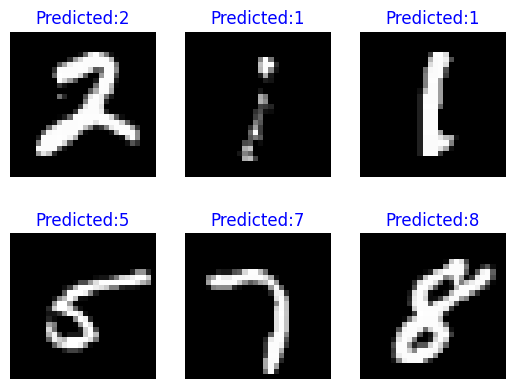

In [17]:
import matplotlib.pyplot as plt

model.set_train(False)
for data, label in test_dataset:
    pred = model(data)
    predicted = mint.argmax(pred, dim=1)
    print(f'Predicted: "{predicted[:6]}", Actual: "{label[:6]}"')

    # 显示数字及数字的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if predicted[i] == label[i] else 'red'
        plt.title('Predicted:{}'.format(predicted[i]), color=color)
        plt.imshow(data.asnumpy()[i][0], interpolation="None", cmap="gray")
        plt.axis('off')
    plt.show()
    break

本案例已同步上线[GitHub仓](https://github.com/mindspore-courses/orange-pi-mindspore/tree/master/Online/01-quick%20start)，更多案例可参考该仓库。

本案例运行所需环境：

| 香橙派AIpro | 镜像 | CANN Toolkit/Kernels | MindSpore |
| :----:| :----: | :----:| :----: |
| 8T 8G | Ubuntu | 8.1.RC1 | 2.6.0 |